# DDPM Training on MNIST with Matern32 GP Noise

This notebook demonstrates training a Denoising Diffusion Probabilistic Model on MNIST using **spatially correlated noise** from a Gaussian Process with Matern 3/2 kernel.

## Why GP-structured noise?

Traditional DDPM uses i.i.d. Gaussian noise (each pixel independent). With GP-structured noise:
- **Spatial correlation**: Nearby pixels have correlated noise
- **Smoother patterns**: Matern 3/2 creates smooth, structured noise patterns
- **Realistic**: Natural images often have spatially correlated structure
- **Efficient**: Using Random Fourier Features avoids expensive kernel computations

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from realistica import (
    NoiseScheduler,
    UNet,
    ImageGPNoiseSampler,
    sample_gp_noise_for_images
)

## Configuration

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
config = {
    'image_size': 28,
    'batch_size': 128,
    'num_epochs': 50,
    'learning_rate': 2e-4,
    'num_timesteps': 1000,
    'beta_start': 0.0001,
    'beta_end': 0.02,
    'schedule_type': 'linear',
    'save_interval': 5,
    # GP noise parameters
    'use_gp_noise': True,
    'gp_lengthscale': 0.15,  # Larger = smoother noise (try 0.1 to 0.3)
    'gp_num_features': 512,  # Number of Fourier features
}

# Create output directories
os.makedirs('outputs/mnist_matern32/samples', exist_ok=True)
os.makedirs('outputs/mnist_matern32/checkpoints', exist_ok=True)

Using device: cpu


## Load MNIST Dataset

In [3]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)}")

Training samples: 60000


## Visualize GP Noise vs Regular Noise

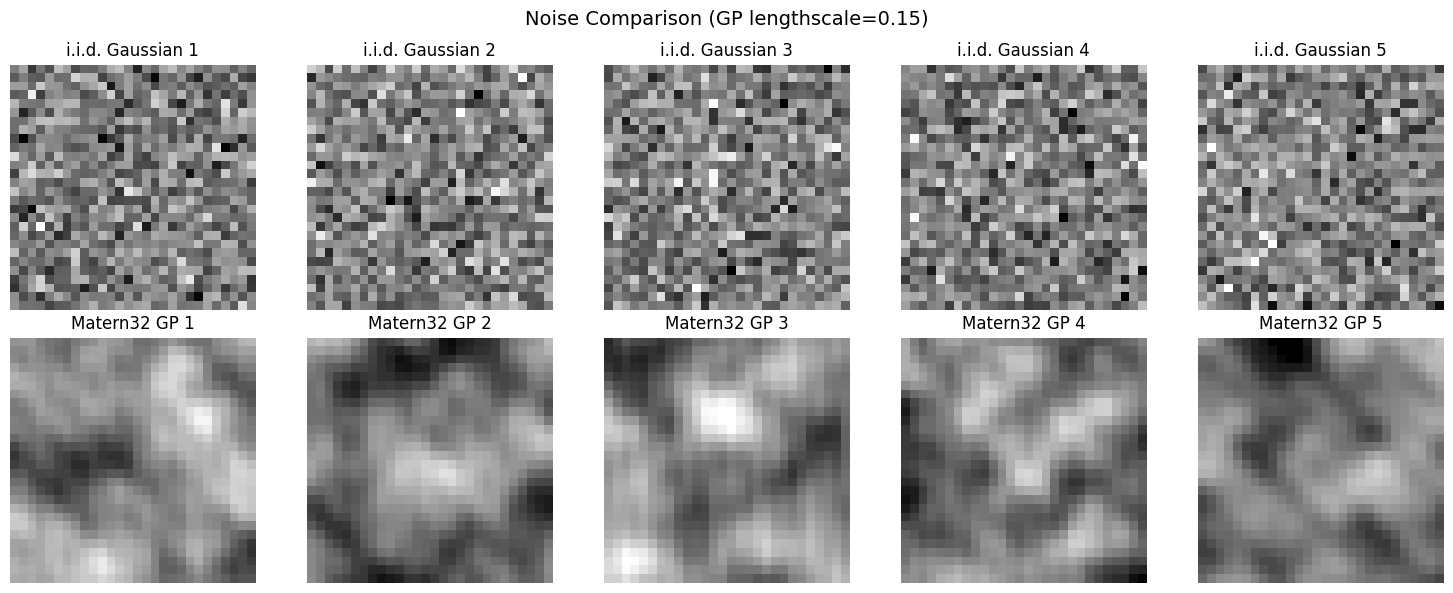

Notice how GP noise has smooth, spatially correlated patterns!


In [4]:
# Compare different noise types
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Regular i.i.d. Gaussian noise
regular_noise = torch.randn(5, 1, 28, 28)
for i in range(5):
    axes[0, i].imshow(regular_noise[i, 0].numpy(), cmap='gray', vmin=-3, vmax=3)
    axes[0, i].set_title(f'i.i.d. Gaussian {i+1}')
    axes[0, i].axis('off')

# GP noise with Matern32
gp_noise = sample_gp_noise_for_images(
    batch_size=5,
    channels=1,
    height=28,
    width=28,
    lengthscale=config['gp_lengthscale'],
    num_features=config['gp_num_features'],
    kernel_type='matern32',
    device=device
)

for i in range(5):
    axes[1, i].imshow(gp_noise[i, 0].cpu().numpy(), cmap='gray', vmin=-3, vmax=3)
    axes[1, i].set_title(f'Matern32 GP {i+1}')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Regular Noise', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('GP Noise (Matern32)', fontsize=12, fontweight='bold')

plt.suptitle(f'Noise Comparison (GP lengthscale={config["gp_lengthscale"]})', fontsize=14)
plt.tight_layout()
plt.show()

print("Notice how GP noise has smooth, spatially correlated patterns!")

## Initialize Model and Noise Scheduler

In [5]:
# Initialize noise scheduler
noise_scheduler = NoiseScheduler(
    num_timesteps=config['num_timesteps'],
    beta_start=config['beta_start'],
    beta_end=config['beta_end'],
    schedule_type=config['schedule_type'],
    device=device
)

# Initialize U-Net model
model = UNet(
    in_channels=1,
    out_channels=1,
    base_channels=64,
    channel_multipliers=(1, 2, 2, 2),
    num_res_blocks=2,
    time_emb_dim=256,
    attention_levels=(False, False, True, True),
    dropout=0.1
).to(device)

# Initialize GP noise sampler for efficiency (reuse across batches)
gp_noise_sampler = ImageGPNoiseSampler(
    height=config['image_size'],
    width=config['image_size'],
    lengthscale=config['gp_lengthscale'],
    variance=1.0,
    num_features=config['gp_num_features'],
    kernel_type='matern32',
    device=device
)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"Using GP noise with lengthscale={config['gp_lengthscale']}")

Model parameters: 8,582,401
Using GP noise with lengthscale=0.15


## Visualize Forward Diffusion with GP Noise

/Users/luisfcd/opt/miniconda3/envs/realistica/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


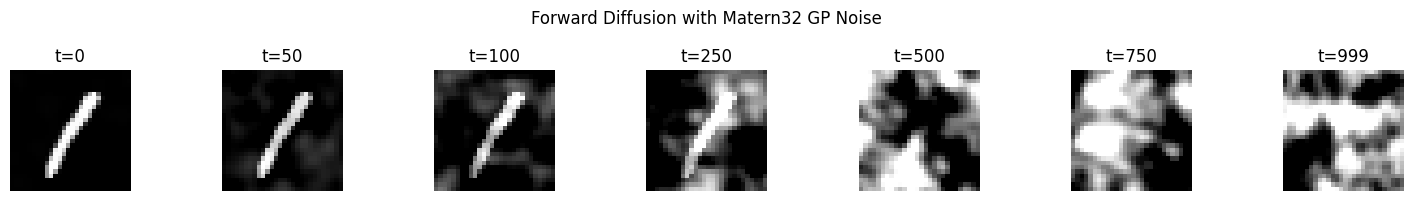

In [6]:
# Show how GP noise is added over time
sample_batch, _ = next(iter(train_loader))
sample_image = sample_batch[0:1].to(device)
timesteps_to_show = [0, 50, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 2))
for idx, t in enumerate(timesteps_to_show):
    t_tensor = torch.tensor([t], device=device)
    
    # Use GP noise instead of regular noise
    noisy_image, _ = noise_scheduler.add_gp_noise(
        sample_image,
        t_tensor,
        gp_noise_sampler=gp_noise_sampler
    )
    
    axes[idx].imshow(noisy_image[0, 0].cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
    axes[idx].set_title(f't={t}')
    axes[idx].axis('off')

plt.suptitle('Forward Diffusion with Matern32 GP Noise')
plt.tight_layout()
plt.show()

## Training Loop with GP Noise

In [ ]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])
criterion = nn.MSELoss()

# Training loop
model.train()
global_step = 0
losses = []

for epoch in range(config['num_epochs']):
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
    
    for batch_idx, (images, _) in enumerate(progress_bar):
        images = images.to(device)
        batch_size = images.shape[0]
        
        # Sample random timesteps
        t = noise_scheduler.sample_timesteps(batch_size)
        
        # Add GP noise to images (KEY CHANGE: using GP noise!)
        if config['use_gp_noise']:
            noisy_images, noise = noise_scheduler.add_gp_noise(
                images, t, gp_noise_sampler=gp_noise_sampler
            )
        else:
            noisy_images, noise = noise_scheduler.add_noise(images, t)
        
        # Predict noise
        predicted_noise = model(noisy_images, t)
        
        # Calculate loss
        loss = criterion(predicted_noise, noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        epoch_loss += loss.item()
        losses.append(loss.item())
        global_step += 1
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.6f}")
    
    # Save checkpoint
    if (epoch + 1) % config['save_interval'] == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'config': config,
        }, f"outputs/mnist_matern32/checkpoints/checkpoint_epoch_{epoch+1}.pt")

print("Training completed!")

Epoch 1/50:  14%|█▎        | 64/469 [03:17<20:21,  3.02s/it, loss=0.14] 

## Sampling with GP Noise

During sampling, we also use GP noise for the stochastic component.

In [ ]:
@torch.no_grad()
def sample_with_gp_noise(model, noise_scheduler, gp_sampler, num_samples=64, image_size=28, device='cpu'):
    """
    Generate samples using DDPM sampling with GP noise
    """
    model.eval()
    
    # Start from GP noise instead of regular noise
    x = gp_sampler.sample(num_samples, 1)
    
    # Reverse diffusion process
    for t in tqdm(reversed(range(noise_scheduler.num_timesteps)), desc='Sampling'):
        t_batch = torch.tensor([t] * num_samples, device=device)
        
        # Predict noise
        predicted_noise = model(x, t_batch)
        
        # Get alpha values
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        
        # Compute x_{t-1}
        if t > 0:
            # Use GP noise for stochastic component
            noise = gp_sampler.sample(num_samples, 1)
        else:
            noise = torch.zeros_like(x)
        
        # DDPM sampling equation
        x = (
            1 / torch.sqrt(alpha) * (
                x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
            ) + torch.sqrt(beta) * noise
        )
    
    model.train()
    return x

# Generate samples
num_samples = 64
samples = sample_with_gp_noise(
    model,
    noise_scheduler,
    gp_noise_sampler,
    num_samples=num_samples,
    image_size=config['image_size'],
    device=device
)

# Visualize
grid = make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Generated MNIST Digits (Matern32 GP Noise)')
plt.tight_layout()
plt.savefig('outputs/mnist_matern32/samples/final_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## Compare Different Lengthscales

Let's see how different GP lengthscales affect the noise patterns.

In [ ]:
lengthscales = [0.05, 0.1, 0.15, 0.2, 0.3]
fig, axes = plt.subplots(len(lengthscales), 5, figsize=(15, 3*len(lengthscales)))

for i, ls in enumerate(lengthscales):
    # Create sampler with this lengthscale
    sampler = ImageGPNoiseSampler(
        height=28, width=28,
        lengthscale=ls,
        num_features=512,
        kernel_type='matern32',
        device=device
    )
    
    # Sample 5 examples
    noise_samples = sampler.sample(5, 1)
    
    for j in range(5):
        axes[i, j].imshow(noise_samples[j, 0].cpu().numpy(), cmap='gray', vmin=-3, vmax=3)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(f'ℓ={ls}', fontsize=12, fontweight='bold')

plt.suptitle('GP Noise Patterns with Different Lengthscales\n(Smaller = More Detail, Larger = Smoother)', 
             fontsize=14)
plt.tight_layout()
plt.show()

## Plot Training Loss

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(losses, alpha=0.6)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'), linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss (Matern32 GP Noise)')
plt.legend(['Raw', 'Smoothed (100-step MA)'])
plt.grid(True, alpha=0.3)
plt.show()

## Save Final Model

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
}, 'outputs/mnist_matern32/checkpoints/final_model.pt')

print("Final model saved!")

## Key Takeaways

1. **GP Noise Structure**: Matern32 creates spatially correlated noise patterns
2. **Lengthscale Control**: Larger lengthscales → smoother noise
3. **Efficient Sampling**: Random Fourier Features make GP sampling fast
4. **Same Training**: The model trains the same way, just with different noise structure
5. **Potential Benefits**: GP noise may help the model learn spatial structure better